# Randomized Maximum Likelihood Solver

This notebook demonstrates the use of the Randomized Maximum Likelihood Solver (RML) implemented in the Pastas-Plugins package. It compares three groundwater model calibration approaches:

Least Squares (LS) with noise model

RML with finite-difference Jacobian

RML with empirical Jacobian

The workflow includes generating synthetic observations, defining the Pastas model structure, running calibrations, generating parameter ensembles, and comparing confidence intervals and simulations.

## Setup

### Packages

The notebook imports numerical and hydrological modeling packages:

In [1]:
import warnings
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pastas as ps

from pastas_plugins.pest.solver import RandomizedMaximumLikelihoodSolver

warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/vonkm/repos/pastas-plugins/pastas_plugins/pest/solver.py:431: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+",
/home/vonkm/repos/pastas-plugins/pastas_plugins/pest/solver.py:549: SyntaxWarning: invalid escape sequence '\s'
  self.temp_ws / "pest.par", index_col=0, sep="\s+", skiprows=[0], header=None
/home/vonkm/repos/pastas-plugins/pastas_plugins/pest/solver.py:555: SyntaxWarning: invalid escape sequence '\s'
  ofr = pd.read_csv(self.temp_ws / "pest.ofr", index_col=0, sep="\s+", skiprows=2)
/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'
/home/vonkm/repos/pastas-plugins/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Data

The notebook loads the Wagna dataset and extracts evaporation and precipitation. These serve as input stresses for the RechargeModel.

In [2]:
df = ps.load_dataset("collenteur_2021")["wagna"]
evap = df["evaporation [mm/d]"].rename("evaporation").dropna()
prec = df["precipitation [mm/d]"].rename("precipitation").loc[evap.index]

### Helper functions

Some helper functions to quickly setup models and synthetic series

In [3]:
def get_model(obs: pd.Series) -> ps.Model:
    """Creates a standard Pastas model template.

    Adds a RechargeModel with a Gamma response function.

    Parameters
    ----------
    obs : pd.Series
        Observations series for the model.

    Returns
    -------
    ps.Model
        The model with RechargeModel and noise model configured.
    """
    ml = ps.Model(obs, name="synthetic_model")
    sms = []
    rm = ps.RechargeModel(
        prec=prec,
        evap=evap,
        rfunc=ps.Gamma(),
        name="rch",
    )
    sms.append(rm)
    ml.add_stressmodel(sms)
    # ml.add_noisemodel(ps.ArNoiseModel())
    return ml


def create_synthetic_series(
    noise_std: float = 0.0, freq: Literal["D", "14D"] = "D"
) -> pd.Series:
    """Generates a synthetic groundwater head time series.

    Builds a model with known parameters, simulates the head time series,
    adds Gaussian noise, and resamples to the chosen frequency.

    Parameters
    ----------
    noise_std : float, optional
        Standard deviation of Gaussian noise to add to observations, by default 0.0
    freq : Literal["D", "14D"], optional
        Resampling frequency ("D" for daily, "14D" for 14-day), by default "D"

    Returns
    -------
    pd.Series
        Synthetic groundwater head observations with realistic but controlled values.
    """
    date_range = pd.date_range(tmin, tmax, freq="D")
    obs = pd.Series(0.0, index=date_range, name="head_obs")
    ml = get_model(obs)
    ml.set_parameter("rch_A", initial=rch_A)
    ml.set_parameter("rch_n", initial=rch_n)
    ml.set_parameter("rch_a", initial=rch_a)
    ml.set_parameter("rch_f", initial=rch_f)
    ml.set_parameter("constant_d", initial=constant_d)
    sim = ml.simulate(tmin=tmin, tmax=tmax)
    if noise_std > 0.0:
        noise = np.random.default_rng(seed=42).normal(0, noise_std, len(sim))
        sim += noise
    sim = ps.timeseries_utils.pandas_equidistant_sample(sim, freq=freq)

    return sim

### Constants

A number of synthetic constants (e.g., rch_A, rch_n, etc.) define the "true" parameters used later in the synthetic model generation.

In [4]:
constant_d = 5.0
rch_A = 0.5
rch_n = 1.1
rch_a = 250.0
rch_f = -0.8
tmin = pd.Timestamp("1980-01-01")
tmax = pd.Timestamp("2019-12-31")

noise_std = 0.025

### Create a synthetic head series

Model is not optimized yet, initial parameters are used.


<Axes: >

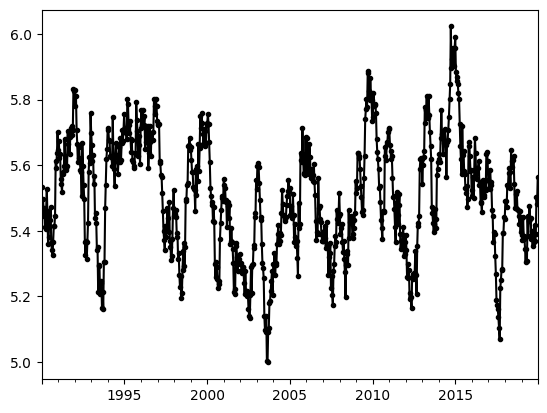

In [5]:
head = create_synthetic_series(noise_std=noise_std, freq="14D")
head = head.loc[pd.Timestamp("1990-01-01") : tmax]
head.plot(marker=".", color="k")

## Models

### Least Squares with Noise Model

A Pastas model (ml_ls) is calibrated with standard least-squares optimization to show as a baseline model to compare the RML uncertainty estimates.

Fit report synthetic_model        Fit Statistics
nfev    11                     EVP         97.94
nobs    783                    R2           0.98
noise   False                  RMSE         0.03
tmin    1990-01-02 00:00:00    AICc     -5762.22
tmax    2019-12-24 00:00:00    BIC      -5738.98
freq    D                      Obj          0.25
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.499871   0.146585  True
rch_n         1.098130   1.000000  True
rch_a       250.819157  10.000000  True
rch_f        -0.807632  -1.000000  True
constant_d    5.008214   5.505771  True


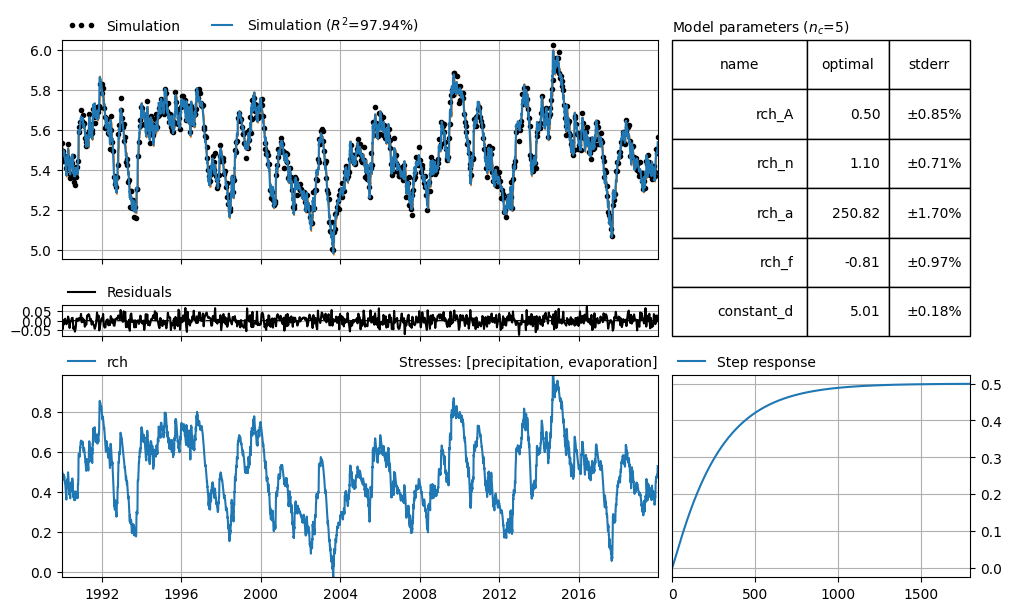

In [6]:
ml_ls = get_model(head)
ml_ls.solve()
axd = ml_ls.plots.results_mosaic(stderr=True)
ci = ml_ls.solver.ci_simulation(n=100)
axd["sim"].fill_between(
    ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="C1", label="90% CI"
)

### RML with finite difference jacobian

In this section we build a model using the Randomized Maximum Likelihood (RML) approach. We apply parameter bounds to constant_d and instantiate the RandomizedMaximumLikelihoodSolver with:
- 1000 realizations, forming the RML parameter ensemble
- A three-point finite-difference Jacobian
    - This means each realization performs its own independent optimization starting from its individually drawn initial parameter set.
    - Each realization computes its own finite-difference Jacobian, just like the standard Pastas least-squares solver.


During `solver.initialize()`, several important steps occur:
- The standard deviation of the observation noise is set via `standard_deviation=noise_std`. This creates a unique synthetic observation series for each ensemble member, representing uncertainty in the measurement data.
- The arguments `method="norm"` and `par_sigma_range=4.0` define how the initial parameter values for each realization are sampled:
    - `method="norm"` → initial parameters are drawn from a normal distribution
    - `par_sigma_range=4.0` → the parameter bounds (pmin, pmax) are interpreted as ±4 standard deviations of this distribution

Together, these settings define the prior parameter ensemble, from which each realization begins its optimization before contributing to the final RML posterior ensemble.

In [7]:
# test finite difference jacobian
ml_rml = get_model(head)
ml_rml.set_parameter(
    "constant_d",
    pmin=ml_rml.parameters.at["constant_d", "initial"]
    - 4 * ml_rml.observations().std(),
    pmax=ml_rml.parameters.at["constant_d", "initial"]
    + 4 * ml_rml.observations().std(),
)

solver = RandomizedMaximumLikelihoodSolver(
    num_reals=250,
    jacobian_method="3-point",  # other option is 2-point which is faster but less accurate for the jacobian
    # num_workers= # if you want to do stuff in parallel, by default yes. if not set num_workers to 1.
)
ml_rml.add_solver(solver)
solver.initialize(
    standard_deviation=noise_std,
    method="norm",
    par_sigma_range=4.0,
)  # method="truncnorm"

Let's have a look at the prior parameter ensemble.

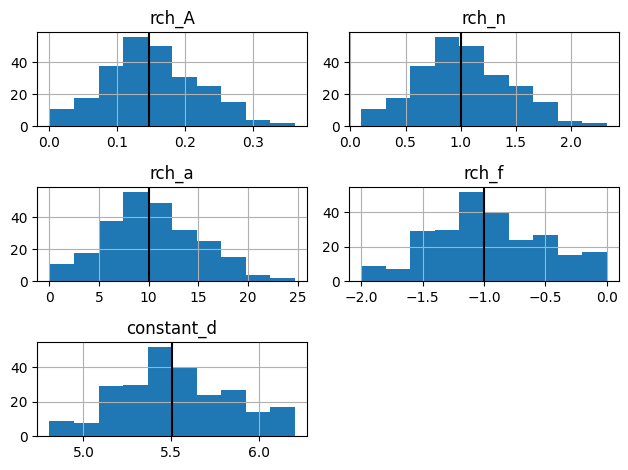

In [8]:
parameter_ensemble_initial = solver.parameter_ensemble.copy()
axes = parameter_ensemble_initial.hist(bins=10)
for ax in axes.ravel():
    title = ax.get_title()
    if title != "":
        ax.axvline(ml_rml.parameters.at[title, "initial"], color="k", label="initial")
plt.tight_layout()

The observation_noise is stored under the `solver.observation_noise`:

In [9]:
solver.observation_noise.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,base
1990-01-02,0.006134,0.013955,0.013881,0.004524,0.048632,0.029283,0.071084,0.031424,0.035165,-0.034352,...,0.013375,0.054584,-0.004218,-0.045778,0.059480,0.034920,0.000397,-0.004454,-0.028481,0.0
1990-01-16,-0.014197,-0.008229,0.019937,-0.012047,-0.006529,0.040086,0.015138,0.013051,0.008746,0.020920,...,-0.000361,-0.031685,0.022145,0.014614,0.010912,-0.025800,-0.030544,0.032909,-0.039762,0.0
1990-01-30,0.019058,-0.010101,-0.010682,0.012991,-0.017553,0.002911,-0.000692,0.010395,-0.029478,0.031204,...,-0.001924,-0.030718,-0.003169,0.048684,-0.035050,-0.037988,0.002104,-0.024062,-0.019232,0.0
1990-02-13,0.004715,-0.020735,0.034227,0.020423,-0.029738,0.001357,0.017137,-0.021774,-0.006873,0.013100,...,-0.022094,0.024990,-0.014745,0.008126,0.019464,0.025633,-0.016064,0.014447,0.024804,0.0
1990-02-27,0.036680,0.001687,-0.004078,-0.023111,0.011612,-0.007555,0.001709,-0.031365,0.025758,0.006708,...,0.038635,-0.029654,0.017224,-0.017976,0.029786,0.024733,-0.015048,0.017223,0.009537,0.0


Together with the `ml.observations()` the observation_noise forms the `solver.observation_ensemble` on which each ensemble is fitted.

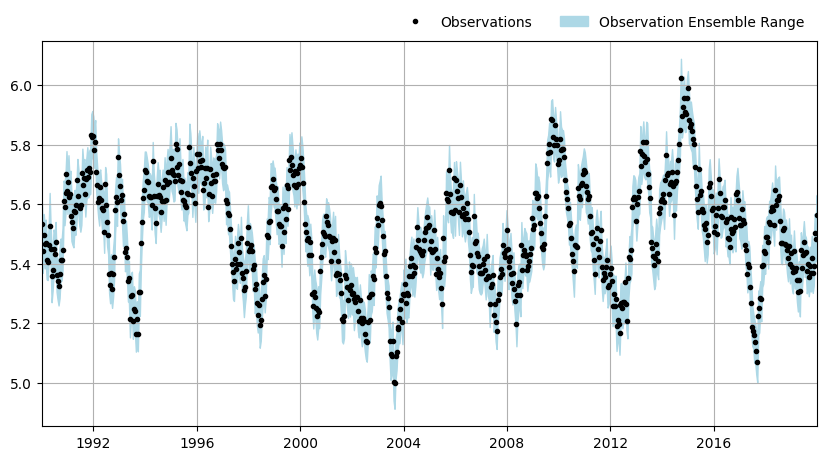

In [10]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    ml_rml.observations().index,
    ml_rml.observations().values,
    "k.",
    label="Observations",
)
ax.fill_between(
    ml_rml.solver.observation_ensemble.index,
    ml_rml.solver.observation_ensemble.min(axis=1),
    ml_rml.solver.observation_ensemble.max(axis=1),
    color="lightblue",
    label="Observation Ensemble Range",
)

ax.set_xlim(ml_rml.observations().index.min(), ml_rml.observations().index.max())
ax.grid(True)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 1.0), ncol=2, frameon=False)

Let's solve this. It might take a minute or if it is done in parallel.

In [11]:
ml_rml.solve(solver=solver, report=True)

RML looping over realizations: 100%|██████████| 250/250 [00:29<00:00,  8.56it/s]


Fit report synthetic_model                      Fit Statistics
nfev    250                    EVP                       97.94
nobs    783                    R2                         0.98
noise   False                  RMSE                       0.03
tmin    1990-01-02 00:00:00    AICc                   -5762.22
tmax    2019-12-24 00:00:00    BIC                    -5738.98
freq    D                      Obj                         nan
warmup  3650 days 00:00:00     ___                            
solver  RandomizedMaximumLikelihoodSolverInterp.                      No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.499872   0.146585  True
rch_n         1.098129   1.000000  True
rch_a       250.819485  10.000000  True
rch_f        -0.807632  -1.000000  True
constant_d    5.008214   5.505771  True


Lets look at the posterior parameter distribution. As you can see the prior is sometimes pretty far away from the posterior. That has to do with how we sample the parameters. Pastas guesses a starting value for `pmin`, `pmax` and `initial` for each parameter (excluding `constant_d`). If dist= `norm` then the bounds are sampled as a normal distribution where `min(initial-pmin, pmax-initial)` is 2 times the standard deviation (`par_sigma_range=4.0`). This means that if `initial` is not halfway between `pmin` and `pmax` the full extent of the original parameter bounds of Pastas are not sampled. I'm also not sure if I'm fully allowed to call it the posterior.

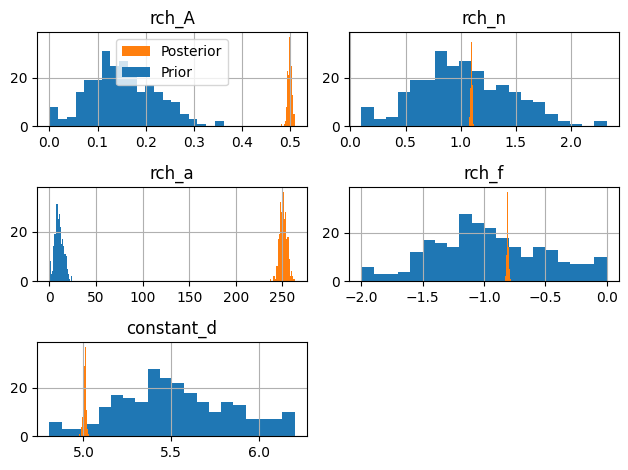

In [12]:
axes = ml_rml.solver.parameter_ensemble.hist(bins=20, color="C1")

for i, ax in enumerate(axes.ravel()[:-1]):
    parameter_ensemble_initial.iloc[:, [i]].hist(bins=20, ax=ax, zorder=0, color="C0")
axes[0, 0].legend(["Posterior", "Prior"])
plt.tight_layout()

Confidence interval is fairly small as is to be expected.

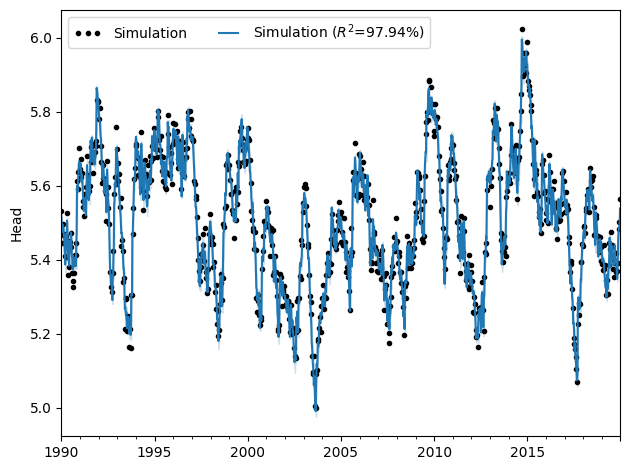

In [13]:
ax = ml_rml.plot()
ax.fill_between(
    ml_rml.solver.simulation_ensemble.index,
    ml_rml.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=0.2,
    color="C0",
)

### RML with empirical jacobian

There is also an option to try the randomized maximum likelihood solver with the emperical jacobian. Here the jacobian is computed from the parameter ensemble and the simulation ensemble. This method is still a bit experimental because the parameter update is done without lambda searching and lambda is just guessed via `lambda = 1e-3 * np.diag(J.T@J)`. Also there is no stopping criteria so the number of optimization steps has to be chosen by hand (`noptmax`).

In [14]:
# test empirical jacobian
ml_rml_em = get_model(head)
ml_rml_em.set_parameter(
    "constant_d",
    pmin=ml_rml_em.parameters.at["constant_d", "initial"]
    - 4 * ml_rml_em.observations().std(),
    pmax=ml_rml_em.parameters.at["constant_d", "initial"]
    + 4 * ml_rml_em.observations().std(),
)

solver = RandomizedMaximumLikelihoodSolver(
    num_reals=250, jacobian_method="empirical", noptmax=10
)
ml_rml_em.add_solver(solver)
solver.initialize(standard_deviation=noise_std, method="norm")
ml_rml_em.solve(solver=solver, report=True)

RML looping over noptmax: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]

Fit report synthetic_model                      Fit Statistics
nfev    10                     EVP                       97.94
nobs    783                    R2                         0.98
noise   False                  RMSE                       0.03
tmin    1990-01-02 00:00:00    AICc                   -5762.15
tmax    2019-12-24 00:00:00    BIC                    -5738.91
freq    D                      Obj                         nan
warmup  3650 days 00:00:00     ___                            
solver  RandomizedMaximumLikelihoodSolverInterp.                      No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         0.500086   0.146585  True
rch_n         1.097951   1.000000  True
rch_a       250.974840  10.000000  True
rch_f        -0.807274  -1.000000  True
constant_d    5.007642   5.505771  True


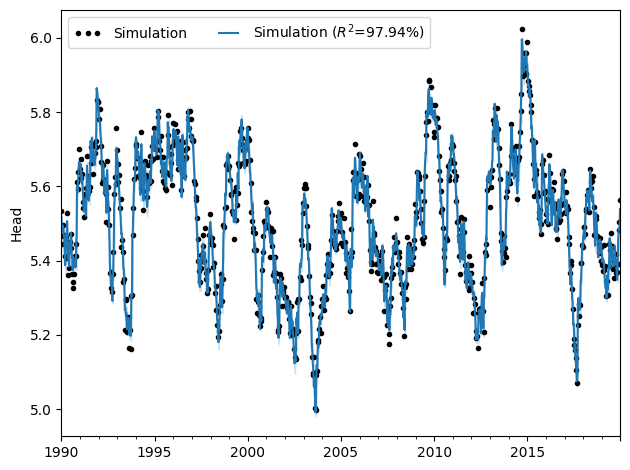

In [15]:
ax = ml_rml_em.plot()
ax.fill_between(
    ml_rml_em.solver.simulation_ensemble.index,
    ml_rml_em.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml_em.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=0.2,
    color="C0",
)

## Compare CI

Lets compare the confidence for the different solvers. It can be clearly seen that the confidnece intervalls are fairly similar for the three different solvers. For the emperical jacobian there are some bigger differences that are observed but pretty much negligable.

In [16]:
ls_ci = pd.DataFrame(
    [
        ml_ls.parameters["optimal"] - 1.96 * ml_ls.parameters["stderr"],
        ml_ls.parameters["optimal"] + 1.96 * ml_ls.parameters["stderr"],
    ],
    index=[0.025, 0.975],
)
rml_ci = ml_rml.solver.parameter_ensemble.quantile([0.025, 0.975])
rmlem_ci = ml_rml_em.solver.parameter_ensemble.quantile([0.025, 0.975])
df = pd.concat([ls_ci, rml_ci, rmlem_ci], keys=["LS", "RML", "RML-EM"], axis=1).T
df.swaplevel(0, 1).sort_index().T.round(3)

constant_d                rch_A                  rch_a           \
              LS    RML RML-EM     LS    RML RML-EM       LS      RML   
0.025      4.990  4.990  4.989  0.492  0.492  0.493  242.486  243.769   
0.975      5.026  5.023  5.023  0.508  0.508  0.508  259.152  259.461   

                rch_f                rch_n                
        RML-EM     LS    RML RML-EM     LS    RML RML-EM  
0.025  243.659 -0.823 -0.820 -0.820  1.083  1.081  1.081  
0.975  259.461 -0.792 -0.791 -0.791  1.113  1.112  1.112

Simulations and confidence intervals in figures also all overlap.

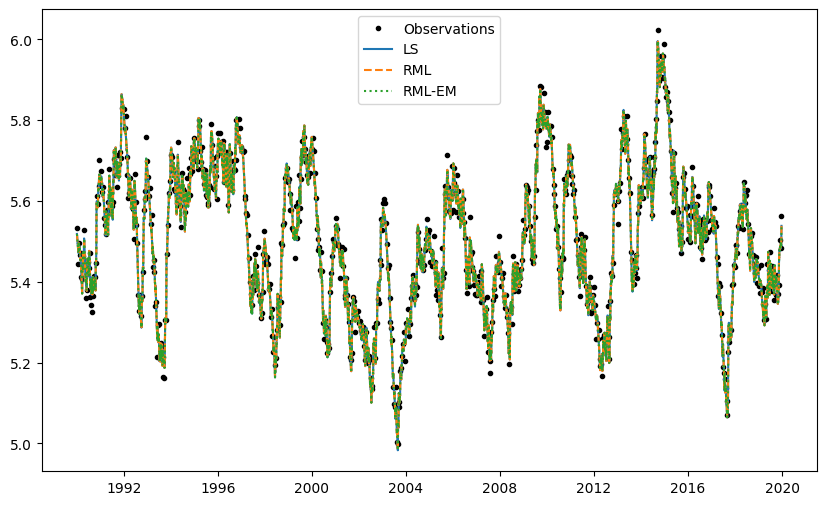

In [17]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    ml_ls.observations(), label="Observations", color="k", linestyle="None", marker="."
)
ax.plot(ml_ls.simulate(), color="C0", linestyle="-", label="LS")
ax.plot(ml_rml.simulate(), color="C1", linestyle="--", label="RML")
ax.plot(ml_rml_em.simulate(), color="C2", linestyle=":", label="RML-EM")
ax.legend()

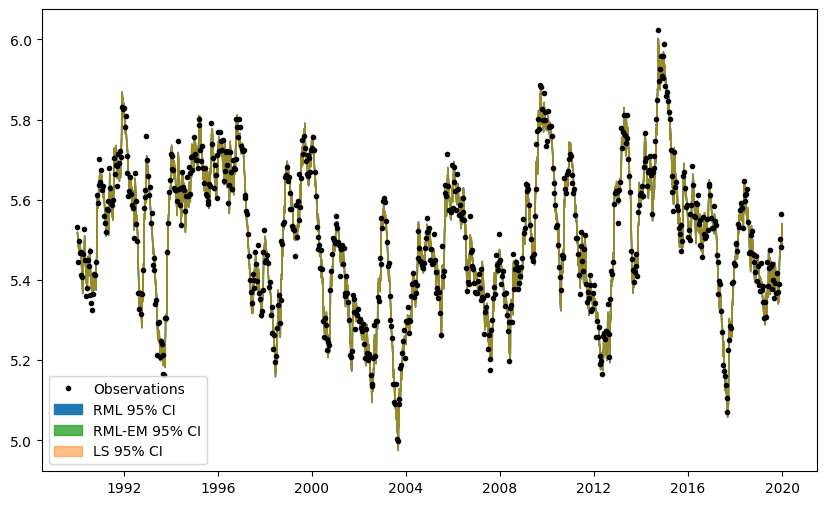

In [18]:
f, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    ml_ls.observations(), label="Observations", color="k", linestyle="None", marker="."
)
ax.fill_between(
    ml_rml.solver.simulation_ensemble.index,
    ml_rml.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=1.0,
    color="C0",
    label="RML 95% CI",
)
ax.fill_between(
    ml_rml_em.solver.simulation_ensemble.index,
    ml_rml_em.solver.simulation_ensemble.quantile(0.025, axis=1),
    ml_rml_em.solver.simulation_ensemble.quantile(0.975, axis=1),
    alpha=0.8,
    color="C2",
    label="RML-EM 95% CI",
)
ci = ml_ls.solver.ci_simulation(n=100)
ax.fill_between(
    ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="C1", label="LS 95% CI", alpha=0.5
)
ax.legend()